In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Paths to dataset directories
train_dir = "../Supervised/dataset/datasetsplitted/train"
val_dir = "../Supervised/dataset/datasetsplitted/val"
test_dir = "../Supervised/dataset/datasetsplitted/test"

In [3]:
# Parameters
IMG_SIZE = (64, 64)  # Use a smaller size for training efficiency
BATCH_SIZE = 32
EPOCHS = 20  # Increase for better performance

In [4]:
# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_dataset = image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 2583 files belonging to 20 classes.
Found 323 files belonging to 20 classes.
Found 329 files belonging to 20 classes.


In [5]:
# Get class names and encode labels
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

label_encoder = LabelEncoder()
label_encoder.fit(class_names)

Found 20 classes: ['Golf', 'bmw serie 1', 'chevrolet spark', 'chevroulet aveo', 'clio', 'duster', 'hyundai i10', 'hyundai tucson', 'logan', 'megane', 'mercedes class a', 'nemo citroen', 'octavia', 'picanto', 'polo', 'sandero', 'seat ibiza', 'symbol', 'toyota corolla', 'volkswagen tiguan']


LabelEncoder()

In [6]:
# Normalize dataset
normalization_layer = layers.Rescaling(1./255)

In [7]:
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [8]:
# Define a custom CNN model with explicit Input
def create_cnn():
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)  # Define functional model properly
    return model


In [9]:
cnn_model = create_cnn()
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss doesn't improve
    patience=5,          # Wait 5 epochs before stopping
    restore_best_weights=True  # Restore the best model
)

# Train CNN with early stopping
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add early stopping here
)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.0872 - loss: 2.9386 - val_accuracy: 0.1053 - val_loss: 2.9194
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.1176 - loss: 2.8967 - val_accuracy: 0.1269 - val_loss: 2.8124
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1638 - loss: 2.7518 - val_accuracy: 0.2477 - val_loss: 2.5376
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.2459 - loss: 2.4759 - val_accuracy: 0.2910 - val_loss: 2.2924
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3375 - loss: 2.1252 - val_accuracy: 0.3932 - val_loss: 1.9389
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4944 - loss: 1.5778 - val_accuracy: 0.5077 - val_loss: 1.5942
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6974 - loss: 1.0138 - val_accuracy: 0.6223 - val_loss: 1.3027
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8252 - loss: 0.5645 - val_accuracy: 0.6625 - v

In [10]:
# Extract Features from CNN
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

In [11]:
def extract_features(dataset, feature_extractor):
    features, labels = [], []
    for images, lbls in dataset:
        features.append(feature_extractor.predict(images))
        labels.extend(lbls.numpy())
    return np.vstack(features), np.array(labels)

In [12]:
# Extract features for XGBoost
X_train, y_train = extract_features(train_dataset, feature_extractor)
X_val, y_val = extract_features(val_dataset, feature_extractor)
X_test, y_test = extract_features(test_dataset, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [13]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', max_depth=7, learning_rate=0.1)

xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],  # Monitor validation performance
    verbose=True
)

[0]	validation_0-mlogloss:2.74823
[1]	validation_0-mlogloss:2.57173
[2]	validation_0-mlogloss:2.43159
[3]	validation_0-mlogloss:2.31566
[4]	validation_0-mlogloss:2.22721
[5]	validation_0-mlogloss:2.14576
[6]	validation_0-mlogloss:2.06932
[7]	validation_0-mlogloss:1.99766
[8]	validation_0-mlogloss:1.93645
[9]	validation_0-mlogloss:1.87845
[10]	validation_0-mlogloss:1.82467
[11]	validation_0-mlogloss:1.77375
[12]	validation_0-mlogloss:1.73071
[13]	validation_0-mlogloss:1.69149
[14]	validation_0-mlogloss:1.65442
[15]	validation_0-mlogloss:1.61959
[16]	validation_0-mlogloss:1.58824
[17]	validation_0-mlogloss:1.55648
[18]	validation_0-mlogloss:1.52766
[19]	validation_0-mlogloss:1.49879
[20]	validation_0-mlogloss:1.47131
[21]	validation_0-mlogloss:1.44873
[22]	validation_0-mlogloss:1.42674
[23]	validation_0-mlogloss:1.40574
[24]	validation_0-mlogloss:1.38775
[25]	validation_0-mlogloss:1.36985
[26]	validation_0-mlogloss:1.35109
[27]	validation_0-mlogloss:1.33218
[28]	validation_0-mlogloss:1.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
# Evaluate on test set
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.729483282674772
                   precision    recall  f1-score   support

             Golf       0.80      0.75      0.77        16
      bmw serie 1       0.86      0.67      0.75         9
  chevrolet spark       0.55      0.55      0.55        11
  chevroulet aveo       0.64      0.69      0.67        13
             clio       0.82      0.89      0.85        35
           duster       0.76      0.79      0.77        28
      hyundai i10       0.91      0.77      0.83        13
   hyundai tucson       0.58      0.54      0.56        13
            logan       0.79      0.92      0.85        12
           megane       0.79      0.68      0.73        28
 mercedes class a       0.67      0.67      0.67         9
     nemo citroen       0.86      0.75      0.80         8
          octavia       0.67      0.62      0.65        16
          picanto       0.73      0.89      0.80        18
             polo       0.57      0.29      0.38        14
          sandero       0.6

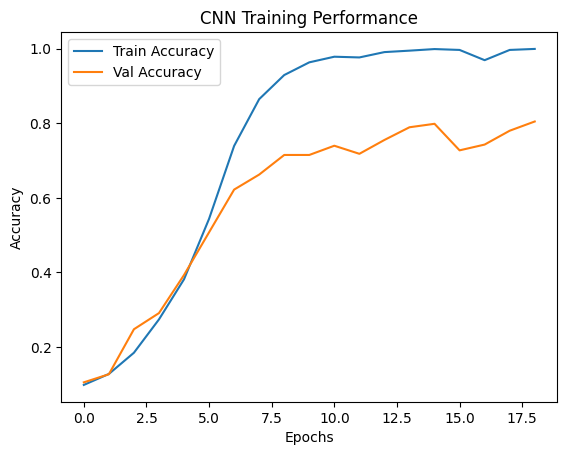

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Training Performance")
plt.show()

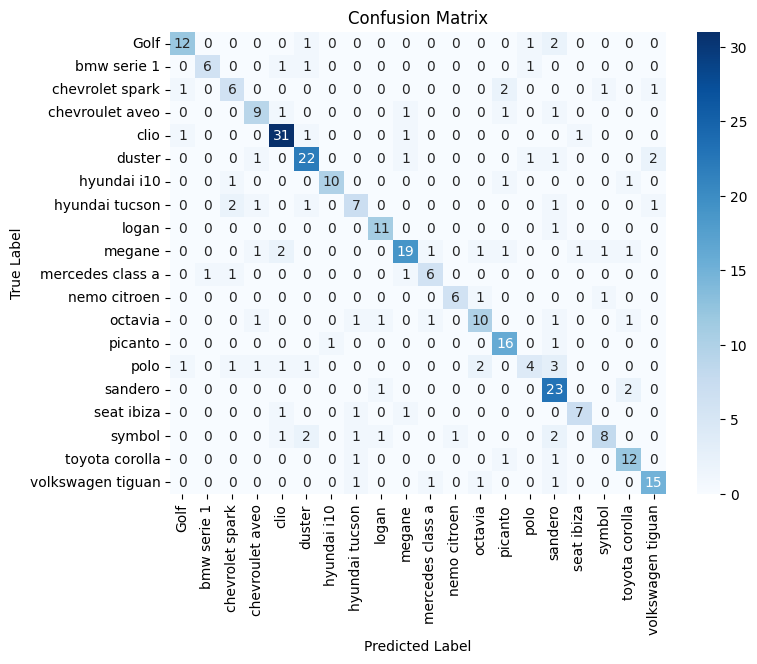

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Compute Hamming Distance
hamming_distance = np.mean(y_pred != y_test)
print(f"Hamming Distance: {hamming_distance}")


Hamming Distance: 0.270516717325228


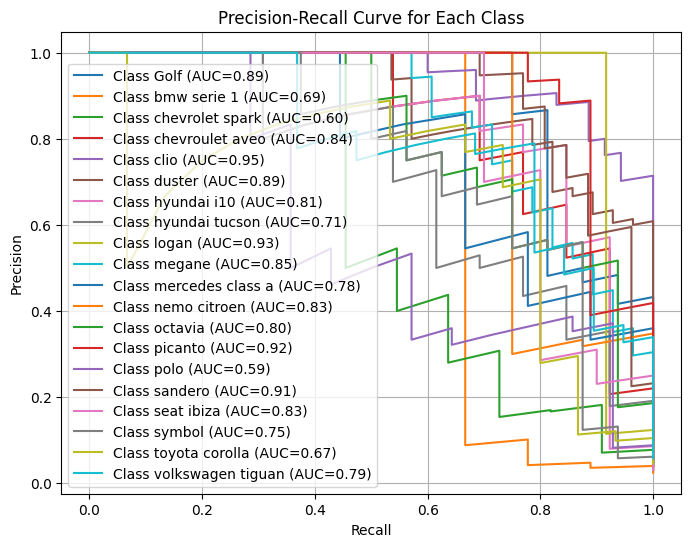

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get probability scores for each class
y_scores = xgb_model.predict_proba(X_test)

# Plot PR Curve for each class
plt.figure(figsize=(8, 6))

for i in range(len(class_names)):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    auc_score = auc(recall, precision)  # Compute AUC-PR
    
    plt.plot(recall, precision, label=f'Class {class_names[i]} (AUC={auc_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid()
plt.show()
